In [6]:
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tensorboardX import SummaryWriter
import csv
from mamba_ssm import Mamba

from draw_util import draw_util
import matplotlib.pyplot as plt

from common import load_csv
from pycamera import triangulate, CameraParam

from typing import Dict, List, Tuple
from omegaconf import OmegaConf
%matplotlib widget
%load_ext autoreload
%autoreload 2
CONFIG = OmegaConf.load('../../conf/config.yaml')
MODEL_CONFIG = CONFIG.model[CONFIG.model_name]
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# toggles
VIEW_TRIANGULATIONS = False




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def get_camera_param_dict() -> Dict[str, CameraParam]:
    '''
        Get camera parameters from config.yaml
    '''
    camera_param_dict = {camera_id: CameraParam.from_yaml(Path(CONFIG.camera.folder) / f'{camera_id}_calibration.yaml') for camera_id in CONFIG.camera.cam_ids}
    return camera_param_dict

def test_camera_torch():
    camera_param_dict = get_camera_param_dict()
    p = np.random.rand(3)*5.0
    p = p.tolist()
    cm = list(camera_param_dict.values())[0]
    print('numpy result',cm.proj2img(np.array(p)))
    cm.to_torch()
    print('torch result', cm.proj2img(torch.tensor(p, dtype=torch.float32)))

test_camera_torch()

class MyDataset(Dataset):
    '''
        Dataset, use numpy array for the convinience of triangulation
    '''
    def __init__(self, csv_file):
        self.data = load_csv(csv_file)
    
    def __len__(self):
        return int(self.data[-1, 0]) + 1 
    
    def __getitem__(self, idx):
        return self.data[idx == self.data[:, 0].astype(int),:]


numpy result [ 103.28804977 -551.86928636]
torch result tensor([ 103.2881, -551.8693])


In [8]:
from lfg.util import compute_stamped_triangulations
    
def view_triangulations():
    '''
        Visualize the 3D positions
    '''
    camera_param_dict = {camera_id: CameraParam.from_yaml(Path(CONFIG.camera.folder) / f'{camera_id}_calibration.yaml') for camera_id in CONFIG.camera.cam_ids}
    dataset = MyDataset(Path(CONFIG.dataset.folder) / CONFIG.dataset.camera_data)

    data = dataset[0]
    stamped_positions = compute_stamped_triangulations(data, camera_param_dict)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(stamped_positions[:,1], stamped_positions[:,2], stamped_positions[:,3], label='3D positions')
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.legend()
    for cm in camera_param_dict.values():
        cm.draw(ax,scale=0.20)
    draw_util.set_axes_equal(ax)
    draw_util.set_axes_pane_white(ax)
    draw_util.draw_pinpong_table_outline(ax)

if VIEW_TRIANGULATIONS:
    view_triangulations()

In [9]:
def get_data_loaders() -> Tuple[DataLoader, DataLoader]:
    '''
        Get the data loaders for training and validation
    '''
    dataset = MyDataset(Path(CONFIG.dataset.folder) / CONFIG.dataset.camera_data)
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, \
                                    [int(len(dataset)*CONFIG.training_data_split), len(dataset) - int(len(dataset)*CONFIG.training_data_split)])
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    return train_loader, test_loader

def get_summary_writer() -> SummaryWriter:
    '''
        Get the summary writer
    '''
    logdir = Path(MODEL_CONFIG.logdir)
    if not logdir.exists():
        logdir.mkdir(parents=True)
        tb_writer = SummaryWriter(logdir=logdir / 'run0')
    else:
        # get the largest number of run in the logdir using pathlib
        logdir = Path(MODEL_CONFIG.logdir)
        paths = list(logdir.glob('*run*'))
        indices = [int(str(p).split('run')[-1]) for p in paths]
        if len(indices) == 0:
            max_run_num = 0
        else:
            max_run_num = max(indices)
        tb_writer = SummaryWriter(logdir=logdir / f'run{1+max_run_num}')
    return tb_writer


def get_model() -> nn.Module:
    '''
        Get the model
    '''
    from functools import partial

    if CONFIG.model_name == 'gru':
        from lfg.model import GRUModel, compute_gru_loss
        model = GRUModel(MODEL_CONFIG.input_size, MODEL_CONFIG.hidden_size, MODEL_CONFIG.num_layers, MODEL_CONFIG.output_size).to(DEVICE)
        loss_fn = partial(compute_gru_loss, image_dim=CONFIG.camera.image_dim)
    elif CONFIG.model_name == 'mamba':
        NotImplementedError

        
    return model, loss_fn

In [10]:
from lfg.util import get_uv_from_3d

    

def test_loss(tb_writer,step_count, model,loss_fn, test_loader,camera_param_dict,criterion):
    '''
        Validate the GRU model
    '''
    with torch.no_grad():
        test_loss = 0.0
        for data in test_loader:
            loss = loss_fn(model, data, camera_param_dict, criterion, CONFIG.estimation_fraction)
            test_loss += loss.item()
        print(f'Validation Loss: {test_loss / len(test_loader)}')
        tb_writer.add_scalars(main_tag='loss', tag_scalar_dict={'testing':test_loss / len(test_loader)}, global_step=step_count)
        
    return test_loss / len(test_loader)

def train_loop():
    '''
        Train the LSTM model
    '''
    # Set seed
    torch.manual_seed(CONFIG.seed)
    np.random.seed(CONFIG.seed)

    # camera files 
    camera_param_dict = {camera_id: CameraParam.from_yaml(Path(CONFIG.camera.folder) / f'{camera_id}_calibration.yaml') for camera_id in CONFIG.camera.cam_ids}
    
    # Load data
    train_loader, test_loader = get_data_loaders()

    # training loop
    model, loss_fn = get_model()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG.lr_init)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=CONFIG.lr_step_size, gamma=CONFIG.lr_gamma)

    # Tensorboard writer
    tb_writer = get_summary_writer()


    step_count = 0
    for epoch in range(CONFIG.num_epochs):
        total_loss = torch.tensor(0.0).to(DEVICE)
        optimizer.zero_grad()
        batch_traj = CONFIG.batch_trajectory
        for i, data in enumerate(train_loader):

            # data (batch_size, seq_len, input_size)
            loss = loss_fn(model, data, camera_param_dict, criterion, CONFIG.estimation_fraction)
            total_loss += loss
            step_count += 1 # for logs

            # batch backward and optimize
            if (i+1) % batch_traj == 0 or i+1 == len(train_loader):
                total_loss /= batch_traj
                # Print loss
                tb_writer.add_scalars(main_tag='loss', tag_scalar_dict={'training':total_loss.item()}, global_step=step_count)
                print(f'Epoch [{epoch+1}/{CONFIG.num_epochs}], Step [{i+1}/{len(train_loader)}], total_loss: {total_loss.item()}')

                # Backward and optimize
                total_loss.backward()
                optimizer.step()
                total_loss = torch.tensor(0.0).to(DEVICE)
                optimizer.zero_grad()
                
        scheduler.step()

        # Test the model every 1 epochs
        if (epoch+1) % 1 == 0:
            test_loss(tb_writer,step_count, model, loss_fn, test_loader,camera_param_dict,criterion)


        # Save model checkpoint
        torch.save(model.state_dict(), MODEL_CONFIG.model_path)
        print("model saved")

    # Close the writer
    tb_writer.close()

train_loop()

Epoch [1/200], Step [20/400], total_loss: 1218.829345703125
Epoch [1/200], Step [40/400], total_loss: 294.4036865234375
Epoch [1/200], Step [60/400], total_loss: 107120.5546875
Epoch [1/200], Step [80/400], total_loss: 3852.760986328125
Epoch [1/200], Step [100/400], total_loss: 6563.89306640625
Epoch [1/200], Step [120/400], total_loss: 65.23467254638672
Epoch [1/200], Step [140/400], total_loss: 39.5881462097168
Epoch [1/200], Step [160/400], total_loss: 51.316646575927734
Epoch [1/200], Step [180/400], total_loss: 1779.4169921875
Epoch [1/200], Step [200/400], total_loss: 11615.7177734375
Epoch [1/200], Step [220/400], total_loss: 25005.259765625
Epoch [1/200], Step [240/400], total_loss: 1903.5906982421875
Epoch [1/200], Step [260/400], total_loss: 106048.6875
Epoch [1/200], Step [280/400], total_loss: 21.688222885131836
Epoch [1/200], Step [300/400], total_loss: 7.1284098625183105
Epoch [1/200], Step [320/400], total_loss: 6.658523082733154
Epoch [1/200], Step [340/400], total_los

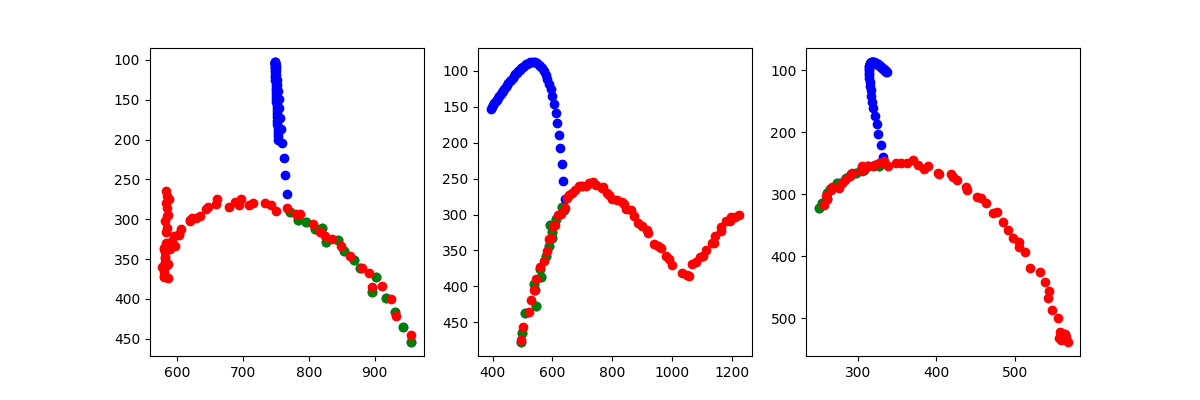

In [ ]:
def predict_result(model, data, camera_param_dict, fraction_est):
    # camera files 
    N_est = int(data.shape[0]*fraction_est)
    for cm in camera_param_dict.values():
        cm.to_numpy()
    stamped_positions = compute_stamped_triangulations(data[:N_est].numpy(), camera_param_dict)
    stamped_positions = torch.from_numpy(stamped_positions).float().to(DEVICE)
    w0 = data[0, 6:9].float().to(DEVICE)
    # Forward pass
    with torch.no_grad():
        y = model(stamped_positions[None,:,:],w0, data[N_est:,0]) # shape is (seq_len-1, 3)

    # back project to image
    for cm in camera_param_dict.values():
        cm.to_torch(device=DEVICE)
    uv_gt = data[1:, 4:6].float().to(DEVICE)
    cam_id_list = [str(int(cam_id)) for cam_id in data[1:, 3]]
    uv_pred = get_uv_from_3d(y, cam_id_list, camera_param_dict)

    return uv_pred

def visualize_predictions():
    # Load data
    train_loader, test_loader = get_data_loaders()
    data = next(iter(test_loader))[0] # ignore the batch size

    # camera files 
    camera_param_dict = {camera_id: CameraParam.from_yaml(Path(CONFIG.camera.folder) / f'{camera_id}_calibration.yaml') for camera_id in CONFIG.camera.cam_ids}
   
    # training loop
    model = get_model()[0]
    state_dict = torch.load(MODEL_CONFIG.model_path)
    model.load_state_dict(state_dict)
    model.eval()


    # predict
    uv_gt = data[1:, 4:6].float().to(DEVICE)
    fraction_est = CONFIG.estimation_fraction
    uv_pred = predict_result(model, data, camera_param_dict, fraction_est)

    # visualize
    fig = plt.figure(figsize=(12,4))
    ax = fig.subplots(1, 3)
    ax = ax.flatten()

    data = data.cpu().numpy()
    N_est = int(data.shape[0]*fraction_est)

    for ax_id, cam_id in enumerate(camera_param_dict.keys()):
        ind = np.where(data[1:, 3].astype(int) == int(cam_id))[0]
        N_ind = len(ind)
        N_est = int(N_ind * fraction_est)
        
        ax[ax_id].scatter(uv_pred[ind, 0].cpu().numpy(), uv_pred[ind, 1].cpu().numpy(), color='blue',label='Prediction')
        ax[ax_id].scatter(uv_pred[ind[:N_est], 0].cpu().numpy(), uv_pred[ind[:N_est], 1].cpu().numpy(), color='green',label='est')
        ax[ax_id].scatter(uv_gt[ind, 0].cpu().numpy(), uv_gt[ind, 1].cpu().numpy(), color='r', label='Ground Truth')
        ax[ax_id].invert_yaxis()
    
    # for axi in ax:
    #     axi.legend()

visualize_predictions()

